In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [3]:
# World Health Organization has set limits for some of the components in the water to determine the portability.

# They are 
# a) ph = (min:6.5, max:8.5)
# b) Solids = (max:1000)
# c) Chloramines = (max:4)
# d) Sulfate = (range(3,30))
# e) Conductivity = (max:400)
# f) Organic_carbon = (max:2)
# g) Trihalomethanes = (max:80)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


### Checking if the Target variable is balanced

Target Variable Balance:
 0    1998
1    1278
Name: Potability, dtype: int64


Text(0.5, 1.0, 'Potability Distribution')

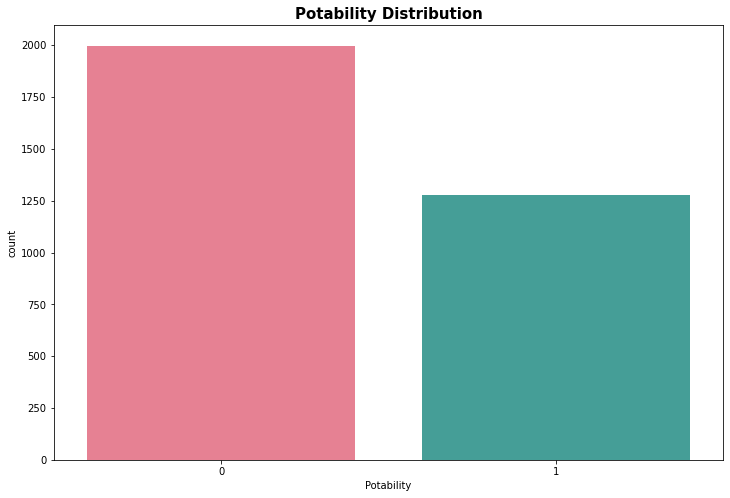

In [5]:
class_balance =df['Potability'].value_counts()
print('Target Variable Balance:\n',class_balance)
plt.figure(figsize=(12,8))
sns.countplot(data = df, x='Potability', palette = 'husl')
plt.title('Potability Distribution',size = 15, weight = 'bold')

Target Variable has a ratio of 61% to 39% ratio. This dataset is not a highly imbalanced dataset. However balancing the target variable may help in our analysis but I am not performing any technique like SMOTE for this analysis

# Handling Missing Values

In [6]:
#pip install missingno

Null Values:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


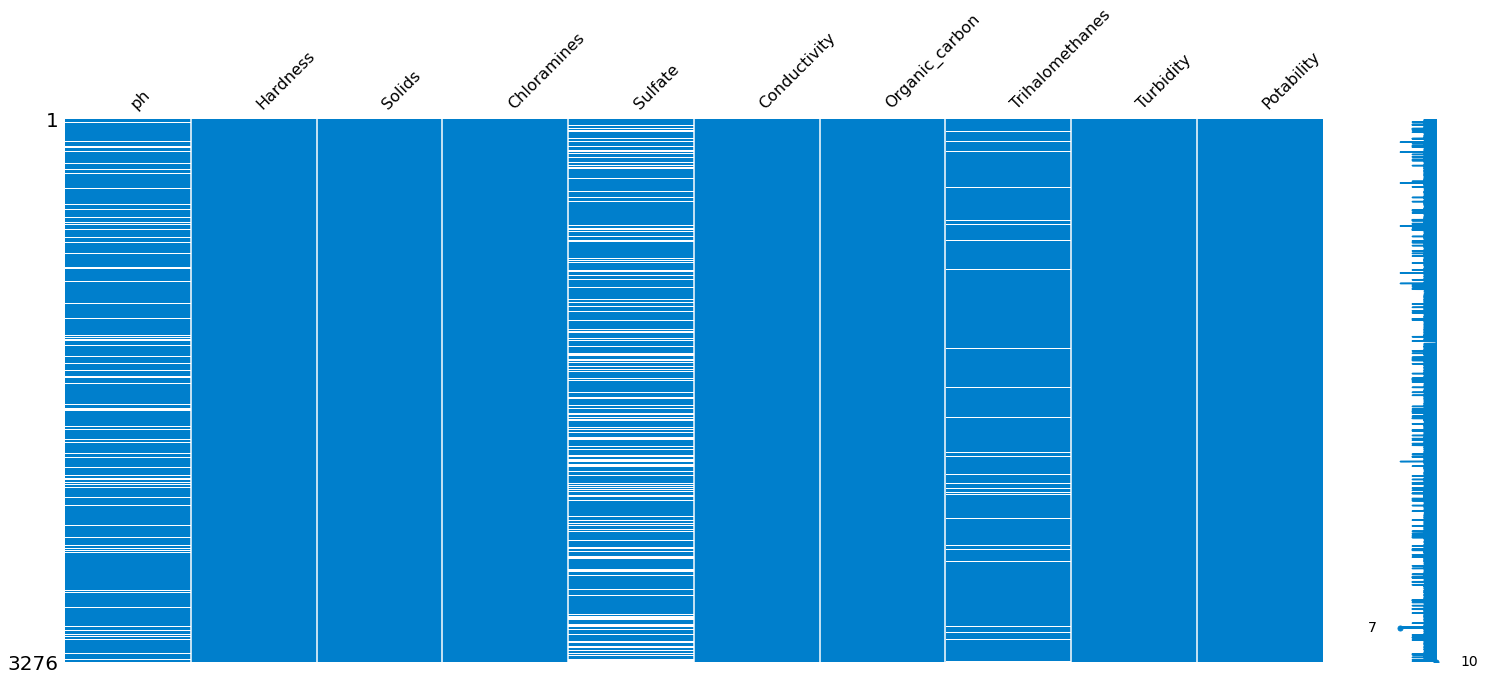

In [7]:
null_info = df.isnull().sum()

import missingno as msno

fig = msno.matrix(df,color=(0,0.5,0.8))

print('Null Values:\n',null_info)

We have null values in 3 variables. Let's deal with them first. We will check how the values are distributed in these columns

<AxesSubplot:>

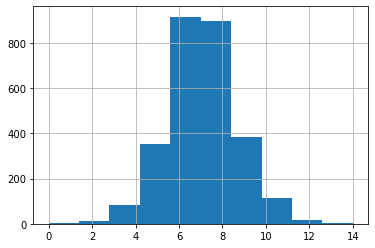

In [8]:
df['ph'].hist()

<AxesSubplot:>

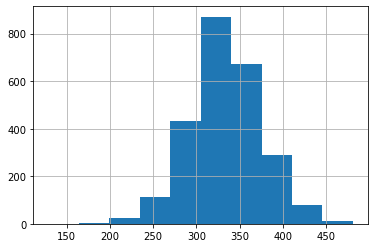

In [9]:
df['Sulfate'].hist()

<AxesSubplot:>

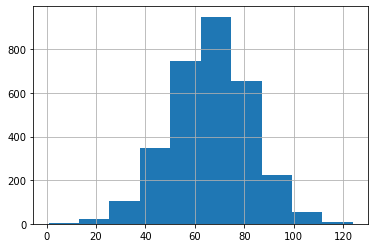

In [10]:
df['Trihalomethanes'].hist()

With the distribution of these columns seen, we can replace the missing values with the mean value.

In [11]:
df['ph'] = df['ph'].fillna(df['ph'].mean())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())


<AxesSubplot:xlabel='ph', ylabel='Sulfate'>

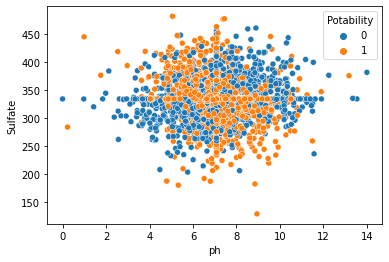

In [12]:
sns.scatterplot(data = df, x= 'ph',y='Sulfate',hue = 'Potability')

In [13]:
# Outliers

In [14]:
from scipy import stats
import numpy as np

z= np.abs(stats.zscore(df))
print(z)

[[8.46038683e-15 2.59194711e-01 1.39470871e-01 ... 1.30614943e+00
  1.28629758e+00 7.99774743e-01]
 [2.28933938e+00 2.03641367e+00 3.85986650e-01 ... 6.38479983e-01
  6.84217891e-01 7.99774743e-01]
 [6.92867789e-01 8.47664833e-01 2.40047337e-01 ... 1.50940884e-03
  1.16736546e+00 7.99774743e-01]
 ...
 [1.59125368e+00 6.26829230e-01 1.27080989e+00 ... 2.18748247e-01
  8.56006782e-01 1.25035206e+00]
 [1.32951593e+00 1.04135450e+00 1.14405809e+00 ... 7.03468419e-01
  9.50797383e-01 1.25035206e+00]
 [5.40150905e-01 3.85462310e-02 5.25811937e-01 ... 7.80223466e-01
  2.12445866e+00 1.25035206e+00]]


In [15]:
print(np.where(z>3))

(array([  37,   61,   66,   80,   88,  104,  140,  245,  253,  263,  263,
        272,  272,  275,  275,  278,  283,  285,  287,  304,  317,  321,
        330,  335,  342,  345,  347,  351,  351,  354,  357,  365,  366,
        379,  382,  383,  385,  434,  492,  509,  531,  546,  666,  680,
        692,  703,  726,  757,  781,  783,  785,  786,  810,  810,  951,
        990, 1031, 1068, 1073, 1075, 1077, 1106, 1123, 1156, 1157, 1186,
       1186, 1290, 1292, 1303, 1316, 1343, 1353, 1360, 1366, 1384, 1412,
       1490, 1523, 1537, 1542, 1554, 1554, 1563, 1605, 1630, 1642, 1743,
       1746, 1766, 1773, 1784, 1792, 1798, 1860, 1892, 1955, 2057, 2075,
       2096, 2121, 2134, 2156, 2189, 2204, 2236, 2302, 2318, 2336, 2343,
       2350, 2353, 2370, 2376, 2401, 2424, 2446, 2447, 2470, 2497, 2602,
       2646, 2646, 2681, 2694, 2699, 2704, 2726, 2757, 2853, 2861, 2868,
       2895, 2899, 2921, 2925, 2928, 2945, 2949, 3014, 3014, 3017, 3020,
       3035, 3042, 3088, 3094, 3130, 3142, 3150, 3

In [16]:
print(z[37][1])

3.2811333826435156


In [17]:
df.shape

(3276, 10)

In [18]:
df = df[(z<3).all(axis=1)]

In [19]:
df.shape

(3128, 10)

<AxesSubplot:>

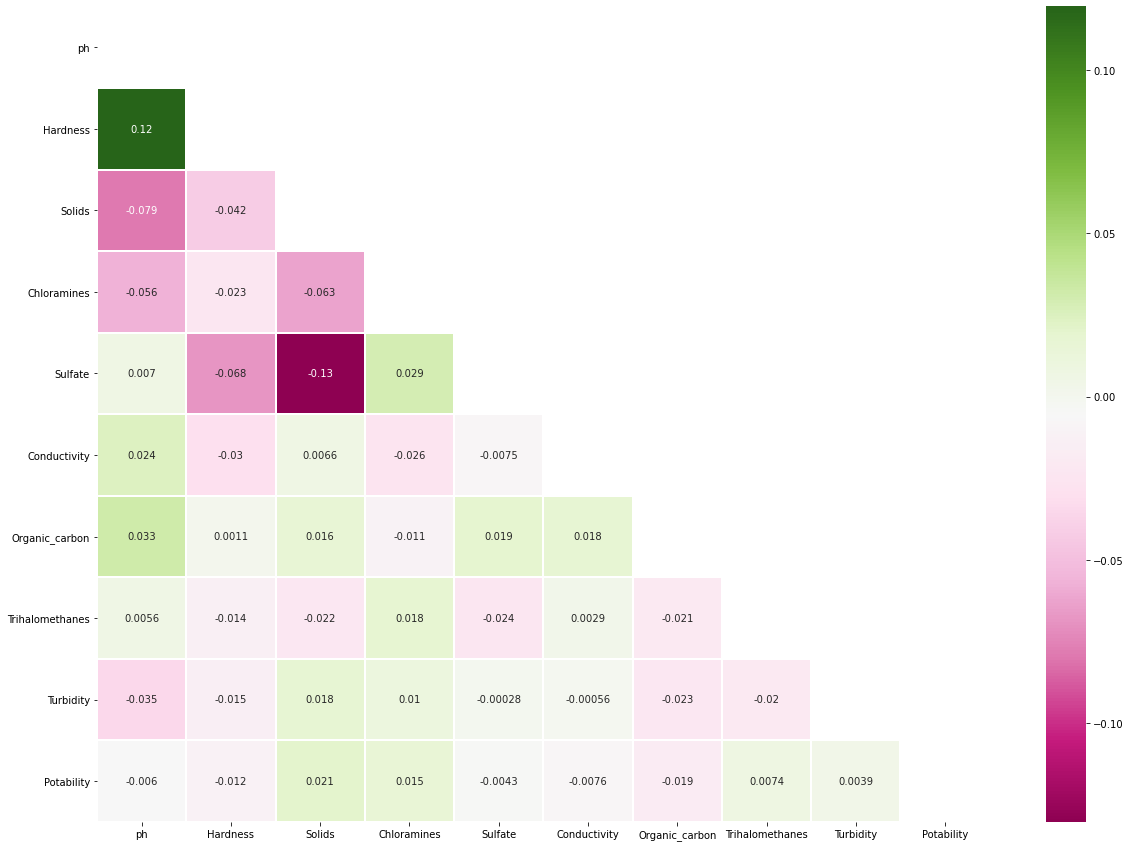

In [20]:
plt.figure(figsize=(20,15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),annot=True,linewidth=1,mask=matrix,cmap='PiYG')

# Splitting the data 

In [21]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier



from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve

from scipy.stats import uniform

In [22]:
# Define our variables and the target label

In [23]:
X = df.drop('Potability', axis = 1)
y = df['Potability']

In [24]:
# Split the original Data into training data and the testing data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)

X_train.shape,y_train.shape

((2658, 9), (2658,))

In [26]:
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

In [27]:
# Lets keep the test data aside to use this at the end when our models are fully built.
# Export the test data which will be used at the end when our models are ready

X_test_df.to_csv('X_test_data',index = False)
y_test_df.to_csv('y_test_data',index = False)

## Dividing the training data into training and validation data

In [28]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42)


In [29]:
X_train_val.shape,y_train_val.shape

((2126, 9), (2126,))

In [30]:
X_test_val.shape,y_test_val.shape

((532, 9), (532,))

In [31]:
X_train_val.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

In [32]:
y_train_val.value_counts()

0    1303
1     823
Name: Potability, dtype: int64

# Standardization

In [33]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_val)
X_test_scaled = sc.transform(X_test_val)

In [34]:
X_train_scaled.shape

(2126, 9)

In [35]:
X_train_scaled

array([[ 1.05920333e+00,  1.85310466e+00,  1.11999381e+00, ...,
        -1.50741074e-01, -2.09148874e+00,  1.39953968e+00],
       [ 5.98924572e-01, -1.90318431e-01, -6.47232702e-01, ...,
         1.03103659e+00,  1.04317855e+00, -1.01199799e-01],
       [-2.35211772e-03, -1.66938656e+00, -2.25767927e-01, ...,
         2.49809306e+00, -8.71059845e-01, -1.37852511e+00],
       ...,
       [-3.85295244e-01, -1.86537519e-01, -7.80309785e-01, ...,
         1.88705487e-01, -3.74631863e-03, -6.79453862e-01],
       [ 1.93642354e+00,  1.51104425e+00, -4.68198669e-01, ...,
         2.86332180e+00,  4.43050221e-01, -2.80714214e-01],
       [-4.60713710e-01, -4.68591906e-01, -4.05164912e-01, ...,
        -1.03040192e-01,  4.92523555e-01, -4.16967611e-02]])

# SVM Model

## Base SVM Model on unscaled data

In [36]:
#Initialize the model
SVC_model = SVC(random_state = 0)

# Fitting the model to our features and labels
SVC_model.fit(X_train_val, y_train_val)

# Traning score for the model
SVC_train_score = SVC_model.score(X_train_val,y_train_val)
print('Initial Training Score :',SVC_train_score)

# Predicting the labels for the test dataset
prediction = SVC_model.predict(X_test_val)

# Calculating the test score
SVC_test_score = accuracy_score(y_test_val, prediction)
print('Initial Testing score:',SVC_test_score)

Initial Training Score : 0.6128880526810913
Initial Testing score: 0.6071428571428571


## Base SVM Model on scaled data

In [37]:
#Initialize the model
SVC_scaled_model = SVC()

# Fitting the model to our features and labels
SVC_scaled_model.fit(X_train_scaled, y_train_val)

# Traning score for the model
SVC_scaled_train_score = SVC_scaled_model.score(X_train_scaled,y_train_val)
print('Scaled Training Score :',SVC_scaled_train_score)

# Predicting the labels for the test dataset
scaled_prediction = SVC_scaled_model.predict(X_test_scaled)

# Calculating the test score
SVC_scaled_test_score = accuracy_score(y_test_val, scaled_prediction)
print('Scaled Testing score:',SVC_scaled_test_score)

Scaled Training Score : 0.7309501411100658
Scaled Testing score: 0.6654135338345865


In [38]:
#Classification Report after scaling

In [39]:
print(classification_report(y_test_val,scaled_prediction, zero_division = True))

              precision    recall  f1-score   support

           0       0.66      0.94      0.77       323
           1       0.73      0.23      0.36       209

    accuracy                           0.67       532
   macro avg       0.69      0.59      0.56       532
weighted avg       0.69      0.67      0.61       532



In [40]:
#Confusion Matrix after scaling

<AxesSubplot:>

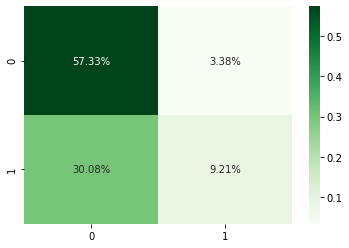

In [41]:
SVC_matrix_scaled = confusion_matrix(y_test_val,scaled_prediction)
sns.heatmap(SVC_matrix_scaled/np.sum(SVC_matrix_scaled),annot = True, fmt = '0.2%',cmap='Greens')

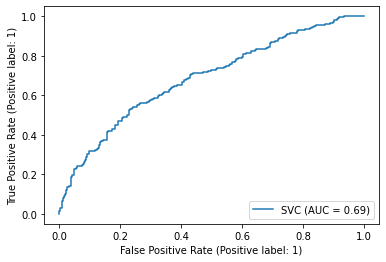

In [42]:
plot_roc_curve(SVC_scaled_model,X_test_scaled,y_test_val)

Lets us see if cross validation improves the performance of the our scaled initial model

In [43]:
SVC_cv_model = SVC()

SVC_cv_scores = cross_validate(SVC_cv_model, X_train_scaled, y_train_val,scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted'], cv = 10)

SVC_cv_scores = pd.DataFrame(SVC_cv_scores, index = range(1,11))

SVC_cv_scores

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted
1,0.177218,0.030689,0.657277,0.656671,0.657277,0.604288
2,0.174890,0.031592,0.680751,0.695693,0.680751,0.633074
3,0.175371,0.031961,0.699531,0.712647,0.699531,0.663402
4,0.173570,0.030758,0.591549,0.540197,0.591549,0.521474
5,0.172725,0.031834,0.680751,0.703604,0.680751,0.631241
6,0.197852,0.031086,0.666667,0.664411,0.666667,0.629273
7,0.166847,0.030181,0.636792,0.635091,0.636792,0.558936
8,0.168193,0.030258,0.669811,0.682864,0.669811,0.617157
9,0.167486,0.030739,0.674528,0.694213,0.674528,0.620828
10,0.169298,0.030601,0.655660,0.650378,0.655660,0.609603


In [44]:
SVC_cv_scores.mean()[2:]

test_accuracy              0.661332
test_precision_weighted    0.663577
test_recall_weighted       0.661332
test_f1_weighted           0.608928
dtype: float64

It has decresed our accuracy as most of validation sets resulted in low performance than expected. 

We haven't choosed any of the parameters as of now while valuating the performance of the model. Let's try parameter tuning to check if it improve the prediction power

## Hyperparameter Tuning for SVC model

Let us try Random Search method to find the best parameter set in the plane.

In [45]:
%%time

SVC_random_model = SVC()

parameters = {'C':[0.1,0.5,1,1.5,5,10],
              'kernel': ['rbf','sigmoid'],
              'gamma':['auto','scale'],
              'degree':[2,3,4]
             }

random_search = RandomizedSearchCV(estimator = SVC_random_model,
                                   param_distributions = parameters,
                                   cv=3)
random_search.fit(X_train_val, y_train_val)
sheet = pd.DataFrame(random_search.cv_results_)
sheet[['param_C','param_kernel','param_degree','param_gamma','mean_test_score']]


CPU times: user 4.39 s, sys: 25.6 ms, total: 4.42 s
Wall time: 4.43 s


,param_C,param_kernel,param_degree,param_gamma,mean_test_score
0,10,sigmoid,3,auto,0.612888
1,1.5,sigmoid,4,auto,0.612888
2,0.1,rbf,2,auto,0.612888
3,0.1,sigmoid,2,scale,0.598764
4,1,rbf,4,scale,0.612888
5,5,sigmoid,3,scale,0.525872
6,1.5,rbf,2,scale,0.612888
7,10,rbf,2,scale,0.612888
8,5,rbf,2,auto,0.612888
9,0.1,rbf,3,auto,0.612888


It has been observed that each kernel can choose its parameters easily. Hence each kernel is taken once at a time. And Linear kernel takes a longer time than usual to fit the datapoints. Hence this kernel is skipped in this analysis.

In [46]:
random_search.best_params_

{'kernel': 'sigmoid', 'gamma': 'auto', 'degree': 3, 'C': 10}

In [47]:
random_model = SVC(C= 0.1,gamma = 'scale', kernel = 'sigmoid')
random_model.fit(X_train_scaled,y_train_val)
train_random_score=random_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Random rbf Training Score :',train_random_score)
test_random_predict = random_model.predict(X_test_scaled)
test_random_score = accuracy_score(y_test_val, test_random_predict)

# Calculating the test score
print('Testing score:',test_random_score)

Random rbf Training Score : 0.6114769520225776
Testing score: 0.6071428571428571


In [48]:
# %%time

# SVC_random_model = SVC()

# parameters = {'C':[0.1,0.3,0.5,0.8,1,3,7],
#               'kernel': ['poly'],
#               'degree':[1,2,3,4,5]
#              }

# random_search = RandomizedSearchCV(estimator = SVC_random_model,
#                                    param_distributions = parameters,
#                                    cv=3)
# random_search.fit(X_train_val, y_train_val)

# random_search.best_params_

Let us test the model with the parameters which we found are the best.

In [49]:

# random_model = SVC(C= 1, kernel = 'poly',degree= 4)
# random_model.fit(X_train_scaled,y_train_val)
# train_random_score=random_model.score(X_train_scaled,y_train_val)
# # Calculating the training score
# print('Random poly Training Score :',train_random_score)

# # test_random_score = random_model.predict(X_test_scaled)
# # test_random_score = accuracy_score(y_test_val, test_random_score)

# # # Calculating the test score
# # print('Testing score:',test_random_score)

From the above two sets of models, we can observe that the poly kernel performs well with this data.

# Using Grid Search to find the Hyperparameters

In [50]:
%%time

C_range = [0.5,1,1.5,2,2.5]

gamma_range = ['auto','scale']

kernel_range = ['rbf','sigmoid']

parameters = dict(gamma = gamma_range, C= C_range, kernel = kernel_range)

grid_SVC = SVC()

grid = GridSearchCV(grid_SVC, param_grid= parameters, cv=5)

grid.fit(X_train_scaled, y_train_val)

grid.best_params_

CPU times: user 16.5 s, sys: 40.7 ms, total: 16.6 s
Wall time: 16.6 s


{'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [52]:
pd.set_option('display.max_rows', 100)
sheet = pd.DataFrame(grid.cv_results_)
sheet[['param_C','param_kernel','param_gamma','mean_test_score']].sort_values(by =['mean_test_score'])

,param_C,param_kernel,param_gamma,mean_test_score
17,2.5,sigmoid,auto,0.538583
13,2,sigmoid,auto,0.539054
19,2.5,sigmoid,scale,0.546107
9,1.5,sigmoid,auto,0.547046
15,2,sigmoid,scale,0.549875
11,1.5,sigmoid,scale,0.551751
7,1,sigmoid,scale,0.563986
5,1,sigmoid,auto,0.567274
1,0.5,sigmoid,auto,0.588906
3,0.5,sigmoid,scale,0.594556


In [53]:
grid_model = SVC(C= 1.5,gamma = 'scale', kernel = 'rbf')
#grid_model = SVC(C= 1.5,gamma = 'scale', kernel = 'rbf')

grid_model.fit(X_train_scaled,y_train_val)
train_grid_score=grid_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Grid Training Score Set 1:',train_grid_score)

test_grid_p = grid_model.predict(X_test_scaled)
test_grid_score = accuracy_score(y_test_val, test_grid_p)

# Calculating the test score
print('Testing score Set 1:',test_grid_score)

Grid Training Score Set 1: 0.7525870178739417
Testing score Set 1: 0.6578947368421053


In [54]:
%%time

C_range = [0.5,1.2,1.5,1.7,2.5,5,10]
# C_range =  [uniform(1,100)]

gamma_range = ['auto','scale']

kernel_range = ['poly']

degree_range = [3,4,5]

parameters = dict(gamma = gamma_range, C= C_range, kernel = kernel_range, degree = degree_range)

grid_SVC = SVC()

grid = GridSearchCV(grid_SVC, param_grid= parameters, cv=5)

grid.fit(X_train_scaled, y_train_val)

grid.best_params_

CPU times: user 36 s, sys: 152 ms, total: 36.1 s
Wall time: 36.4 s


{'C': 1.2, 'degree': 4, 'gamma': 'auto', 'kernel': 'poly'}

In [55]:
pd.set_option('display.max_rows', 100)
sheet = pd.DataFrame(grid.cv_results_)
sheet[['param_C','param_kernel','param_degree','param_gamma','mean_test_score']].sort_values(by =['mean_test_score'])

,param_C,param_kernel,param_degree,param_gamma,mean_test_score
41,10,poly,5,scale,0.595009
40,10,poly,5,auto,0.595009
34,5,poly,5,auto,0.606766
35,5,poly,5,scale,0.607237
23,1.7,poly,5,scale,0.608653
22,1.7,poly,5,auto,0.608653
28,2.5,poly,5,auto,0.608654
37,10,poly,3,scale,0.608662
36,10,poly,3,auto,0.609131
29,2.5,poly,5,scale,0.609593


Applying this parameters to our model to check the performance.

In [ ]:
grid_model = SVC(C= 1.2,gamma = 'auto', kernel = 'poly', degree = 4)
#grid_model = SVC(C= 1.5,gamma = 'scale', kernel = 'rbf')

grid_model.fit(X_train_scaled,y_train_val)
train_grid_score=grid_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Grid Training Score :',train_grid_score)

test_grid_p = grid_model.predict(X_test_scaled)
test_grid_score = accuracy_score(y_test_val, test_grid_p)

# Calculating the test score
print('Testing score:',test_grid_score)

In [ ]:
plot_roc_curve(grid_model,X_test_scaled,y_test_val)

From the above two models we can choose Random Search model as our final parameters

In [ ]:
final_parameters = {'C':[76],
              'kernel': ['rbf'],
              'gamma':['auto'],
              'degree':[2]
             }

## Best Model

In [ ]:
%%time

best_SVC_model = SVC(C= 1,gamma = 'scale', kernel = 'poly',degree= 4)
best_SVC_model.fit(X_train_scaled,y_train_val)
train_best_SVC_score=best_SVC_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Training Score :',train_best_SVC_score)

test_best_predict= best_SVC_model.predict(X_test_scaled)
test_best_score = accuracy_score(y_test_val, test_best_predict)

# Calculating the test score
print('Testing score:',test_best_score)

In [ ]:
best_SVC_matrix = confusion_matrix(y_test_val,test_best_predict)
plot_confusion_matrix(best_SVC_model,X_test_scaled,y_test_val)
# sns.heatmap(best_SVC_matrix/np.sum(best_SVC_matrix),annot = True, fmt = '0.2%',cmap='Greens')

In [ ]:
plot_roc_curve(best_SVC_model,X_test_scaled,y_test_val)

Our final model is ready and lets apply this on our test data set.

# Standardise the test data set

In [ ]:
check

# Running our test model and checking our accuracy

# MLP Model

In [ ]:
# pip install skorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

### We will define the initial parameters needed for our multilayer perceptron

In [ ]:
input_dim = X_train_val.shape[1]
hidden_dim = 100
output_dim = 2
dropout = 0.5
activation = F.relu
device ='cpu'

In [ ]:
print('Input Size:',input_dim,
      'Hidden Size:', hidden_dim,
      'Output Size:',output_dim)

### Building a basic neural network

In [ ]:
class MLP(nn.Module):
    def __init__(
            self,
            input_size = input_dim,
            hidden_size = hidden_dim,
            output_size = output_dim,
            dropout = dropout,
            activation = activation
    ):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output_size = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = self.activation(self.fc1(X))
        X = self.dropout(X)
        X = self.activation(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.output_size(X), dim = -1)
        
        return X

Building a model using the network

In [ ]:
torch.manual_seed(0)

MLP_model = NeuralNetClassifier(
    MLP,
    max_epochs = 20,
    lr = 0.1,
    device = device)

Converting the double datatype to float datatype

In [ ]:

X_train_scaled = X_train_scaled.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)


Fit the model into our dataset

In [ ]:
MLP_model.fit(X_train_scaled, y_train_val)

Let us use this model to predict our target variables and see the predictions on the validation dataset

In [ ]:
mlp_pred = MLP_model.predict(X_test_scaled)

mlp_pred_score = accuracy_score(y_test_val, mlp_pred)

print('Initial Testing Score:',mlp_pred_score)

Early Stopping is found to be useful many scenarios. Hence we will try this on our model

In [ ]:
MLP_model = NeuralNetClassifier(
    MLP,
    lr = 1,
    max_epochs = 100,
    callbacks = [EarlyStopping()]
    )

In [ ]:
MLP_model.fit(X_train_scaled,y_train_val)

In [ ]:
mlp_pred = MLP_model.predict(X_test_scaled)

mlp_pred_score = accuracy_score(y_test_val, mlp_pred)

print('Testing Score after using Early Stopping:',mlp_pred_score)

It indeed increased the performance of our model.

Lets Check if Cross Validation can improve our model.

In [ ]:
scores = cross_validate(MLP_model, X_train_scaled, y_train_val, scoring = 'accuracy', cv =4)

In [ ]:
scores

From the scores of the cross validation process, we can observe that the performance of the model hasn't changed much on an average. 

# MLP Hyperparameter Optimization

In [ ]:
# Setting a base model without any parameters

#criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

MLP_model = NeuralNetClassifier(
    MLP,
    criterion = criterion,
    callbacks = [EarlyStopping()]
    )

## Using Random Search to find the best parameters

In [ ]:

MLP_model.set_params(verbose=0)

params = {   'lr': [0.0001,0.001,0.01],
             'batch_size': [250,300,350],
             'optimizer':[optim.Adam, optim.SGD],
             'module__hidden_size': [50,100,200],
             'module__dropout': [0.2,0.3,0.5],
             'module__activation':[F.relu, F.selu,F.leaky_relu],
             'max_epochs': [200,400,500]
         }

random_MLP = RandomizedSearchCV(MLP_model,
                           params,
                           cv=3,
                           scoring = 'accuracy')

random_MLP.fit(X_train_scaled, y_train_val);

In [ ]:
random_MLP.best_score_, random_MLP.best_params_

## Using Grid Search to find the best parameters

In [ ]:
%%time
MLP_model.set_params()

params = {'lr': [0.001,0.01],
         'optimizer':[optim.Adam, optim.SGD],
         'batch_size': [250,300,350],
         'max_epochs': [500],
         'module__hidden_size': [50,100,150],
         'module__dropout': [0.3,0.4,0.5]
         }

grid_MLP = GridSearchCV(MLP_model,
                       params,
                       cv=3,
                       scoring = "accuracy"
                       )


grid_MLP.fit(X_train_scaled, y_train_val)

In [ ]:
grid_MLP.best_score_, grid_MLP.best_params_

# Best Model 

Let us re build our base model with the values obtained from the GridSearchCV method.

In [ ]:
input_dim = X_train_val.shape[1]
hidden_dim = 50
output_dim = 2
dropout = 0.5
activation = F.relu

In [ ]:
class MLP(nn.Module):
    def __init__(
            self,
            input_size = input_dim,
            hidden_size = hidden_dim,
            output_size = output_dim,
            dropout = dropout,
            activation = activation
    ):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.output_size = nn.Linear(hidden_size, output_size)
        
    def forward(self, X):
        X = self.activation(self.fc1(X))
        X = self.dropout(X)
        X = self.activation(self.fc2(X))
        X = self.dropout(X)
        X = F.softmax(self.output_size(X), dim = -1)
        
        return X

From the above methods we can determine the best parameters suited for our model.

In [ ]:
# Best Parameters
batch_size = 250
lr = 0.001
epochs = 500
optimizer = optim.Adam
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()

Building our final model with the parameters choosen above

In [ ]:
torch.manual_seed(0)

MLP_best = NeuralNetClassifier(
            MLP,
            max_epochs = epochs,
            batch_size = batch_size,
            optimizer = optimizer,
            criterion = criterion,
            lr = lr,
            callbacks = [EarlyStopping()]
            )
MLP_best.fit(X_train_scaled, y_train_val)

In [ ]:
MLP_best_pred = MLP_best.predict(X_test_scaled)

MLP_best_pred_score = accuracy_score(y_test_val, MLP_best_pred)

print('Final Testing Score on train data:',MLP_best_pred_score)

# Standardise the test data set

In [ ]:
scs = StandardScaler()
X_train = scs.fit_transform(X_train)
X_test = scs.transform(X_test)

In [ ]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Running our test model and checking our accuracy

In [ ]:
final_MLP_model = MLP_best.predict(X_test)

final_MLP_model_score = accuracy_score(y_test, final_MLP_model)

print('Final Testing Score on testing data:',final_MLP_model_score)



In [ ]:
# Importing the test data and running our best models.

In [ ]:
X_test = pd.read_csv('X_test_data')
X_test

In [ ]:
# SVM Final Model

In [ ]:
# scs = StandardScaler()
# X_train = scs.fit_transform(X_train)
# X_test = scs.transform(X_test)

In [ ]:
# %%time

# # final_SVC_model = SVC(C= 1,gamma = 'auto', kernel = 'rbf',degree= 2)
# # final_SVC_model.fit(X_train,y_train)
# # train_final_SVC_score=final_SVC_model.score(X_train,y_train)
# # # Calculating the training score
# # print('Training Score :',train_final_SVC_score)

# test_final_SVC = best_SVC_model.predict(X_test)
# test_final_SVC_score = accuracy_score(y_test, test_final_SVC)

# # Calculating the test score
# print('Final Model Testing score:',test_final_SVC_score)

Final Results from both the models

In [ ]:
print('Final Model Testing score:',test_final_SVC_score)
print('Final Testing Score on testing data:',final_MLP_model_score)


# 